<img src="./fiuba.jpg" align="right" width="150" /> 
#### Procesamiento Digital de Señales

# Trabajo Práctico 1
#### Lucas Dórdolo

***
## Procesos Aleatorios



**Recepción de una señal degradada:**

+ Un receptor de comunicaciones posee un frontend analógico que recibe señales moduladas en PAM (Pulse Amplitude Modulation), por medio de pulsos de forma exponencial.
+ El canal por el cual viajan estos pulsos es un canal AWGN (Additive White Gaussian Noise), por lo cual la señal recibida se verá degradada notablemente. En principio, se puede suponer que afecta de forma independiente a cada muestra de la señal.
+ Se dispone una trama digitalizada muestrada a 20 samples / pulso. La trama contiene un header de 16 bytes donde cada byte es: 10101100. La modulación empleada es antipodal:
    - pulso positivo -> bit 1
    - pulso negativo -> bit 0

**Notas:**

+ La señal se encuentra sincronizada a nivel muestra. Por esta razón, la muestra 0 corresponde al comienzo de un pulso exponencial.
+ Tener en cuenta que el objetivo es recuperar la información, lo cual no implica recuperar fielmente la señal enviada. Esto es clásico en problemas de comunicaciones: sabemos la forma de la modulación (la forma de los pulsos y como se modulan), lo que no sabemos es con qué valores fueron modulados.

**Objetivos principales:**
+ Detectar la secuencia de bits recibida de forma confiable
+ Investigar diferentes métodos de demodulación
Para ello se pide:

PARTE 1
+ a) Filtrar la señal con un filtro digital para eliminar potencia de ruido. Pueden probar con filtros FIR o IIR, los que les parezcan convenientes. ¿Es óptimo el filtro elegido para detectar la información en forma confiable?
+ b) Definir un umbral que permita tomar decisiones ("vino un 1" o "vino un 0") para cada pulso y reconstruir la trama enviada. Nuevamente, ¿Es óptimo ese umbral?

PARTE 2
+ Repetir el procedimiento para la parte 1, pero utilizar el filtro y el umbral óptimo.

In [75]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sc 
import scipy.io.wavfile 
from scipy import signal



Importo las señales a usar. Puede seleccionarse:
- signalLowSNR.npy: tiene una menor relación señal a ruido con lo que permite una detección más precisa.
- signal.npy: el nivel de ruido es mayor, con lo que se dificulta la detección.

In [76]:
# si viene un 1 transmito pulse
#si viene un 0 transmito -pulse
# entonces hay 20 muestras por cada dato.

pulso = np.load('pulse.npy')
#senial = np.load('signalLowSNR.npy')
senial = np.load('signal.npy')

byte = np.concatenate((pulso,-pulso,pulso,-pulso,pulso,pulso,-pulso,-pulso)) 
header = np.concatenate((byte,byte,byte,byte,byte,byte,byte,byte,byte,byte,byte,byte,byte,byte,byte,byte))


A continuación graficamos el pulso que se utilizó para sobremuestrear la señal. Se ve una forma exponencial, con una gran amplitud inicial que decae rápidamente.

Text(0, 0.5, 'Amplitud')

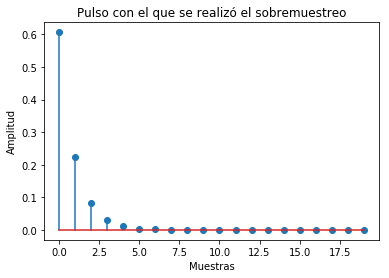

In [88]:
plt.figure(1)

plt.stem(pulso)
plt.title('Pulso con el que se realizó el sobremuestreo')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')

Text(0, 0.5, 'Amplitud')

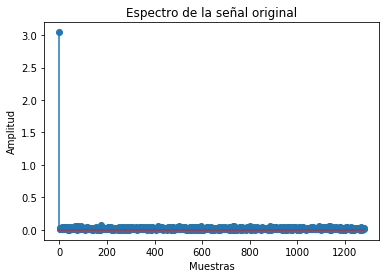

In [77]:
fs = len(header)
NN = fs
#Arreglo de frecuencias del espectro
ff = np.linspace(0, fs//2, NN//2).flatten()
#Calculamos espectro
spectrum = (2/NN)*np.abs(sc.fftpack.fft(senial[1:len(header)]))    
 #Nos quedamos con la primer mitad del espectro
halfSpectrum = spectrum[:NN//2] 

plt.figure(2)

plt.stem(ff, halfSpectrum)
plt.title('Espectro de la señal original')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')

Text(0, 0.5, 'Amplitud')

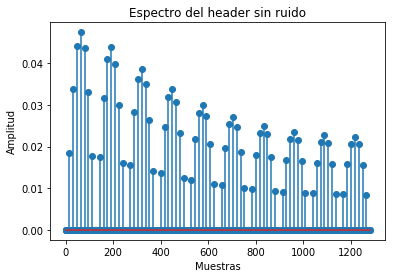

In [89]:
fs = len(header)
NN = fs
#Arreglo de frecuencias del espectro
ff = np.linspace(0, fs//2, NN//2).flatten()
#Calculamos espectro
spectrum = (2/NN)*np.abs(sc.fftpack.fft(header))    
 #Nos quedamos con la primer mitad del espectro
halfSpectrum = spectrum[:NN//2] 
plt.figure(1)

plt.stem(ff, halfSpectrum)
plt.title('Espectro del header sin ruido')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')

Puede verse fácilmente que debido al ruido adicionado, el espectro original posee una gran amplitud en frecuencia cero. Por esta razón se optó por realizar un filtro pasa-altos.

Text(0, 0.5, 'Amplitud')

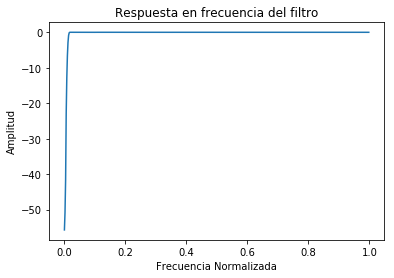

In [80]:
filtro = signal.firwin(499 ,0.01, pass_zero=False)

ww, hh = signal.freqz(np.array(filtro), 1)
ww = ww / np.pi

plt.figure(3)

plt.plot(ww, 20 * np.log10(abs(hh)))
plt.title('Respuesta en frecuencia del filtro')
plt.xlabel('Frecuencia Normalizada')
plt.ylabel('Amplitud')



Al filtrar la señal con el pasa-altos se obtiene la forma de onda y espectro siguientes.

Text(0, 0.5, 'Amplitud')

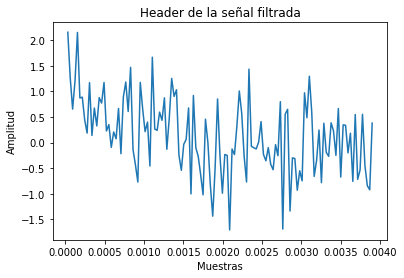

In [81]:
N = len(senial)
fs = N
t = np.linspace(0, (N-1)/fs, N).flatten()

y_pa = signal.filtfilt(filtro,1,senial.flatten())

plt.figure(4)
plt.plot(t[1:128], y_pa[1:128])

plt.title('Header de la señal filtrada')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')


Text(0, 0.5, 'Amplitud')

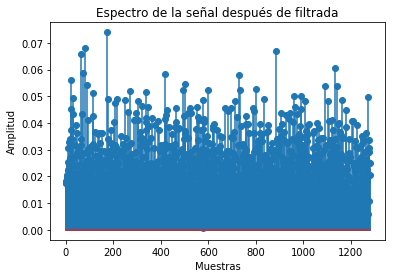

In [82]:
fs = len(header)
NN = fs
#Arreglo de frecuencias del espectro
ff = np.linspace(0, fs//2, NN//2).flatten()
#Calculamos espectro
spectrum = (2/NN)*np.abs(sc.fftpack.fft(y_pa[1:len(header)]))    
 #Nos quedamos con la primer mitad del espectro
halfSpectrum = spectrum[:NN//2] 

plt.figure(2)

plt.stem(ff, halfSpectrum)
plt.title('Espectro de la señal después de filtrada')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')

Resulta evidente que en este caso la amplitud del espectro de la señal filtrada es comparable a la del espectro del header sin ruido adicional. 
Para realizar el submuestreo, se toma la primera muestra de cada pulso por ser la que posee mayor amplitud.
Se grafica byte a byte cómo fue detectado el header.

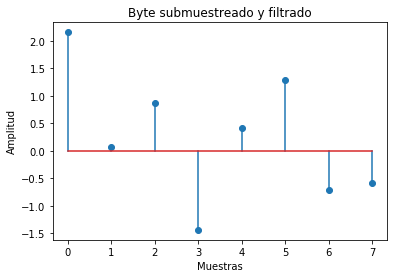

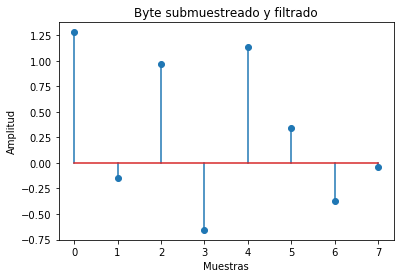

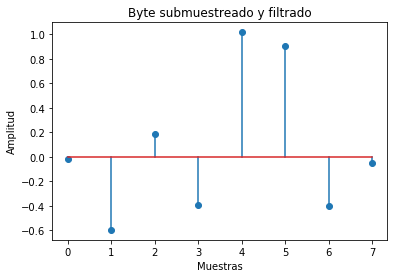

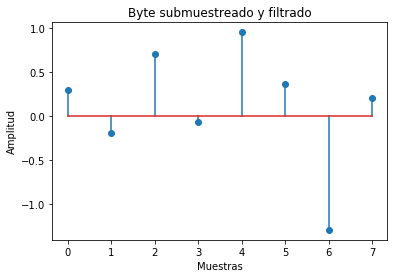

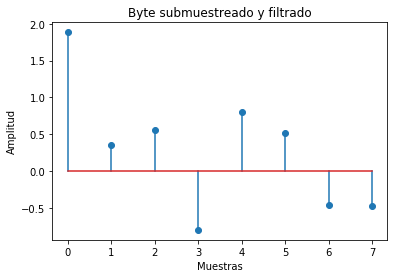

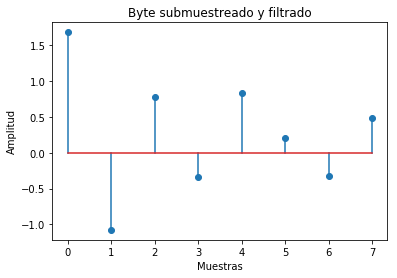

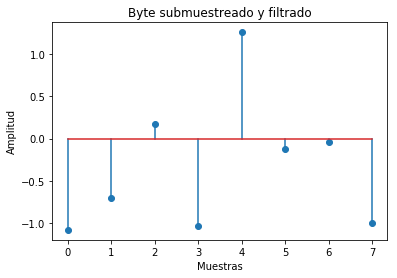

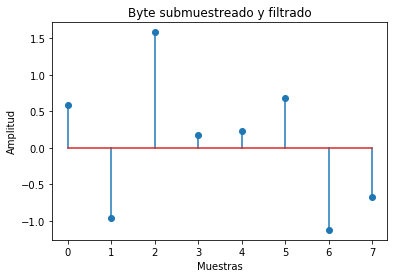

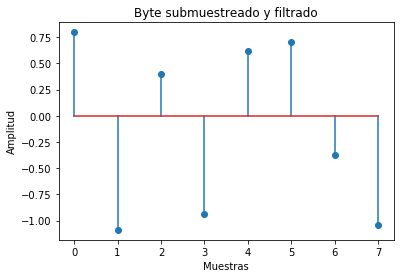

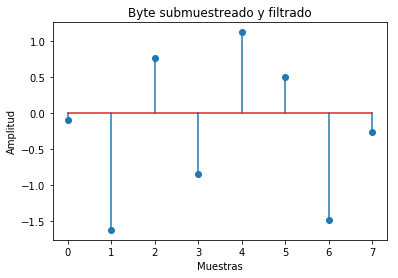

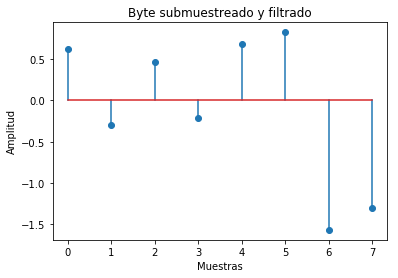

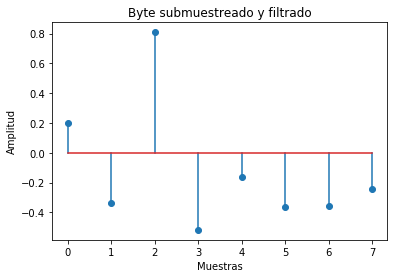

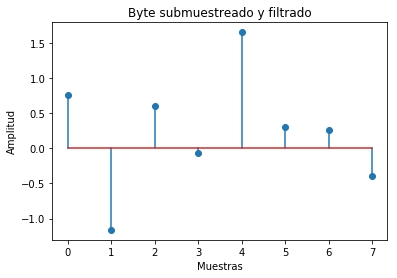

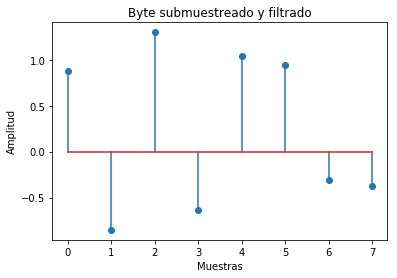

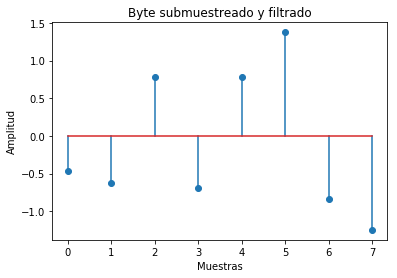

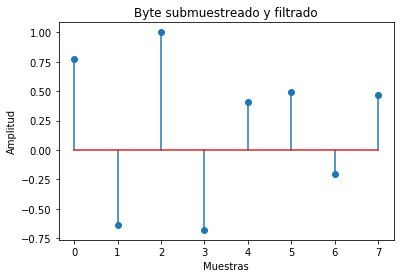

In [83]:
submuestreo = y_pa[1::20]
for i in range(16):
    plt.figure(i)
    plt.stem(submuestreo[i*8:i*8+8])
    plt.title('Byte submuestreado y filtrado')
    plt.xlabel('Muestras')
    plt.ylabel('Amplitud')


Por último seleccionamos como umbral de detección 0.1, considerándose un 1 todo nivel por encima de este y 0 al nivel que no lo alcance.
Esto permite un resultado óptimo en la detección del header en la señal de bajo SNR, pero en el otro caso presenta varios errores.

In [86]:
nivel_detectado = np.zeros(len(submuestreo),dtype = int)
for a in range(0,len(submuestreo)):
    if (submuestreo[a] > 0.1 ):
        nivel_detectado[a] = 1;
    else:
        nivel_detectado[a] = 0;



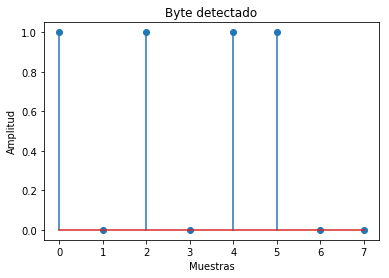

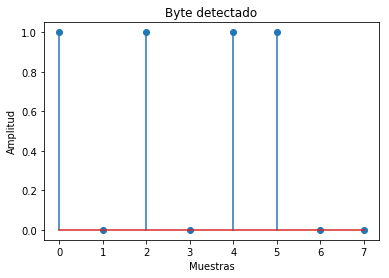

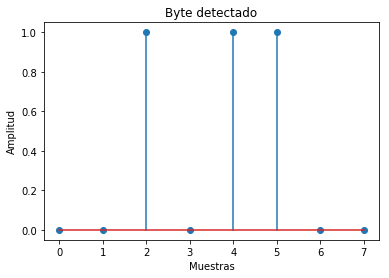

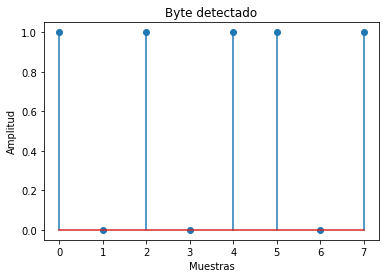

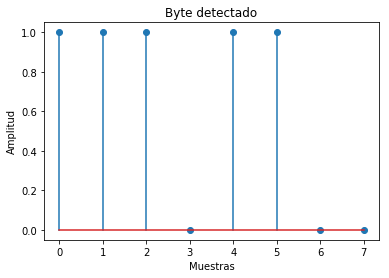

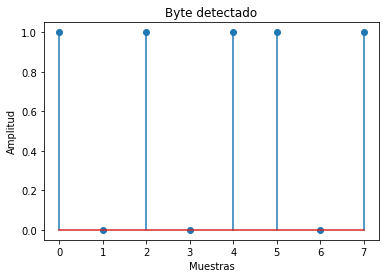

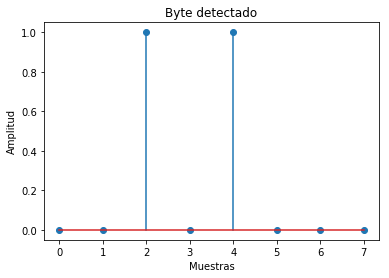

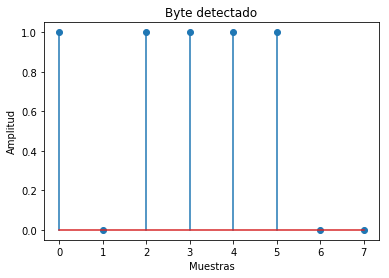

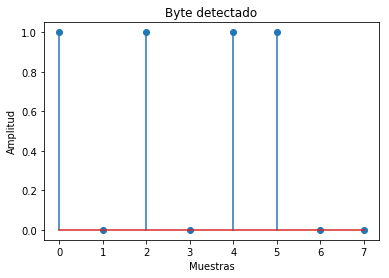

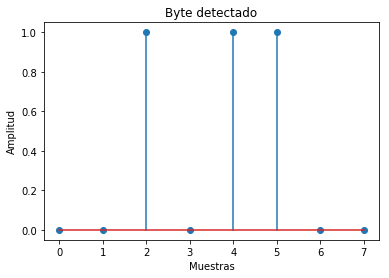

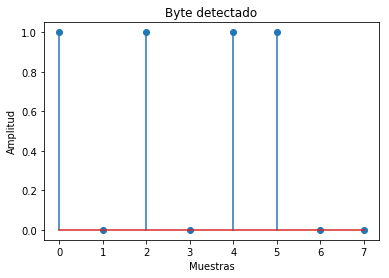

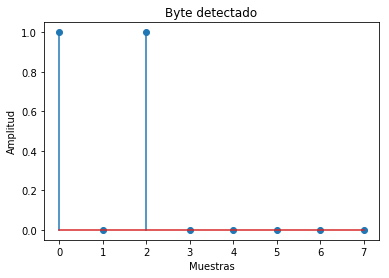

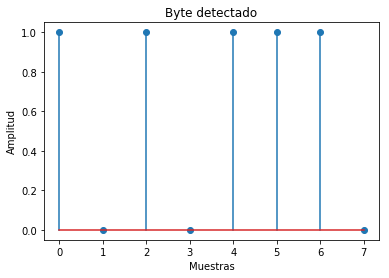

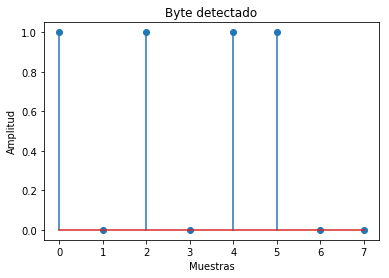

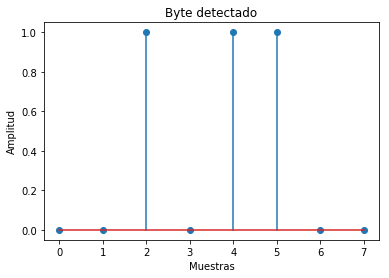

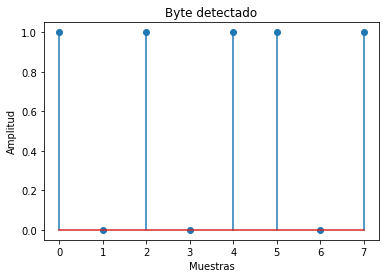

In [87]:
for i in range(16):
    plt.figure(i)
    plt.stem(nivel_detectado[i*8:i*8+8])
    plt.title('Byte detectado')
    plt.xlabel('Muestras')
    plt.ylabel('Amplitud')